In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [8]:
import requests

# Data downloaded as XLS from https://results.enr.clarityelections.com/GA/Fulton/105430/web.264614/#/detail/1
# worksheet 1 saved to csv to ga_fulton_county.csv

data = pd.read_csv('ga_fulton_county.csv', skiprows=1)

In [10]:
data.head(3)

,Unnamed: 0,Unnamed: 1,Donald J. Trump (I) (Rep),Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Joseph R. Biden (Dem),Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Jo Jorgensen (Lib),Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,County,Registered Voters,Election Day Votes,Advanced Voting Votes,Absentee by Mail Votes,Provisional Votes,Total Votes,Election Day Votes,Advanced Voting Votes,Absentee by Mail Votes,Provisional Votes,Total Votes,Election Day Votes,Advanced Voting Votes,Absentee by Mail Votes,Provisional Votes,Total Votes,Total
1,01A,0,41,143,50,0,234,160,1638,703,0,2501,3,10,9,0,22,2757
2,01B,0,79,158,57,0,294,242,1824,878,0,2944,11,16,15,0,42,3280


In [14]:
# data = pd.read_csv('data/ga_fulton_county.csv', skiprows=2)
data = data[data.columns[[0, 6, 11, 16]]]

# first column is mislabled (not County)
data.columns = ['Precinct', 'Donald Trump', 'Joe Biden', 'Jo Jorgensen']

In [18]:
data = data.set_index('Precinct')
data.head(3)

,Donald Trump,Joe Biden,Jo Jorgensen
Precinct,,,
01A,234,2501,22
01B,294,2944,42
01C,49,710,13


In [24]:
unstacked_data = data.unstack().reset_index().rename(
    columns={0: 'count', 'level_0': 'candidate'})
unstacked_data = unstacked_data[['candidate', 'count', 'Precinct']]
unstacked_data['count'] = unstacked_data['count'].astype(int)
unstacked_data.head(3)

,candidate,count,Precinct
0,Donald Trump,234,01A
1,Donald Trump,294,01B
2,Donald Trump,49,01C


Text(0.5, 0.98, 'Fulton County Precincts, N=385')

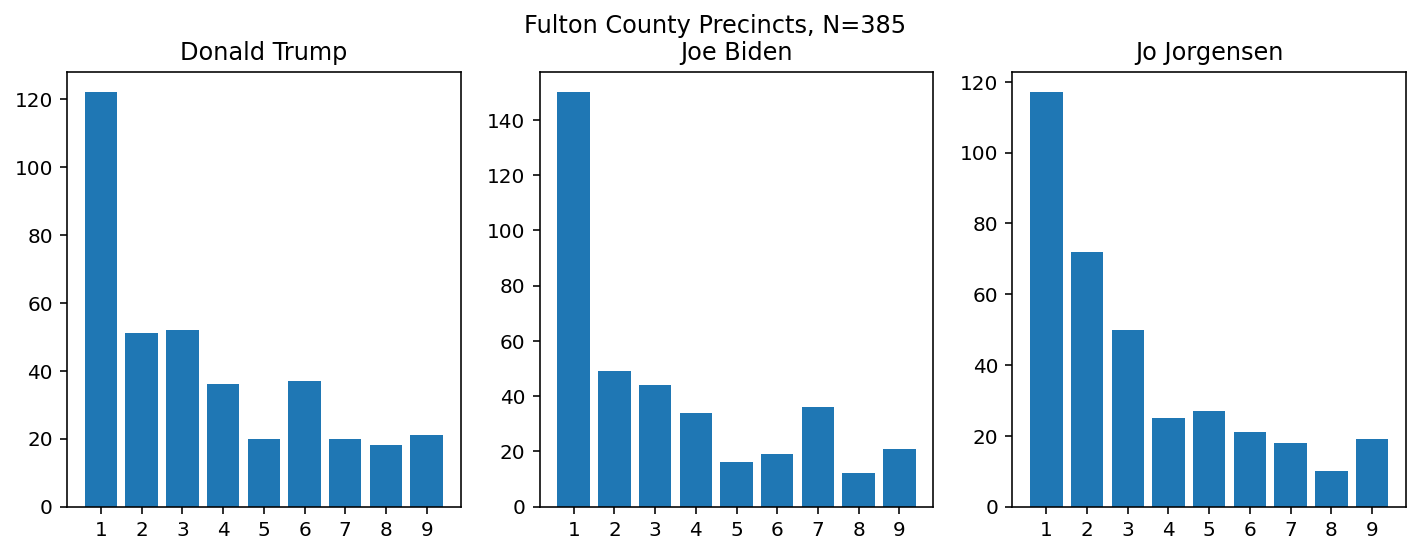

In [29]:

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = np.array(axs).flatten()
candidates = unstacked_data.candidate.unique()

for i in range(len(candidates)):

    ax = axs[i]
    candidate = candidates[i]
    cur_data = unstacked_data
    cur_data = cur_data.groupby(['candidate', 'Precinct']).sum()
    digits = cur_data.loc[candidate]['count'].astype(str).str[0].astype(int)
    digits = digits[digits > 0]
    
    v = digits.value_counts()
    ax.bar(v.index, v.values)
    ax.set_xticks(range(1, 10))

    ax.set_title("%s" % (candidate))

plt.suptitle("Fulton County Precincts, N=%d" % len(data))
    